#### Using neural networks to model halo-galaxy connection

- Predicting galaxy **stellar mass** given some **halo properties** using a **Neural Networks**:

#### Sumary

1) Galaxy-Halo Connection
2) Libraries
3) Handling data  
3.1) Getting and analysing the data   
3.2) Data pre-processing  
3.3) Measuring the correlation among halo/galaxy properties

#### 1) Galaxy-Halo Connection

#### 2) Libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error
import wget

In [22]:
import matplotx
plt.style.use(matplotx.styles.github["dark"])

#### 3) Handling data
The dataset we are going to use it's a **IllustrisTNG** box from a single snapshot (z = 0) from the **CAMELS** simulations. More information about the simulation and data is given in the CAMELS **documentation** page. 

#### 3.1) Getting and analysing the data

In [2]:
wget.download('https://www.dropbox.com/scl/fi/c7wrsplqjr5b0xwgy1cri/fof_subhalo_tab_033.hdf5?rlkey=1hve3qo7nrdh5qolesfclhlf5&st=p91k9axo&dl=0', 'data/fof_subhalo_tab_033.hdf5')

'data/fof_subhalo_tab_033 (1).hdf5'

In [3]:
with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


The cosmological information used to run this simulation can be obtained using:

In [4]:
with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    BoxSize         = f['Header'].attrs[u'BoxSize']/1e3
    scale_factor    = f['Header'].attrs[u'Time']   
    redshift        = f['Header'].attrs[u'Redshift']   
    h               = f['Header'].attrs[u'HubbleParam']  
    Omega_m         = f['Header'].attrs[u'Omega0']    
    Omega_L         = f['Header'].attrs[u'OmegaLambda']    

In [5]:
print('Box size: %.2f Mpc/h' %BoxSize)
print('snapshot redshift: %.2f' %redshift)
print('Omega_m: %.3f' %Omega_m)
print('Omega_L %.3f' %Omega_L)

Box size: 25.00 Mpc/h
snapshot redshift: 0.00
Omega_m: 0.300
Omega_L 0.700


Getting the properties of the **Groups** (contains the properties of the halos) and the **Subhalos** (contains properties of the subhalos, like galaxies, that are considered as subhalos with stellar mass larger than 0).

In [6]:
c = 3.*10**8

with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h = f['Group/Group_M_Crit200'][:]*1e10 #Msun/h
    R_h = f['Group/Group_R_Crit200'][:]/c    #kpc/h   
    V_h = f['Group/GroupVel'][:]            #km/s   
    V_h = np.linalg.norm(V_h, axis = 1)
    ID_r = f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h = np.arange(0, M_h.shape[0], 1, dtype = float) #ID of the halos, match de gal cat
    
    # Positions, stellar masses of the galaxies
    SM = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs
    

The number of halos is not necessary the same as the number of galaxies, because we can have halos without and with more than one galaxy:

In [7]:
M_h.shape, SM.shape

((20131,), (17176,))

Selecting only the halos which have galaxies:

In [8]:
indexes = np.where(ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Then, we have the halo (with galaxies) catalog:

In [9]:
# Halo catalog
data = np.array([M_h, R_h, V_h, ID_h]).T
columns = ['M_h', 'R_h', 'V_h', 'ID']
halos = pd.DataFrame(data = data, columns = columns)
halos.head(5)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0
3,1.533784e+13,0.000001,29.311657,3.0
4,1.587606e+13,0.000001,201.305161,4.0


In [10]:
# Galaxy catalog
data = np.array([SM, ID_g]).T
columns = ['SM', 'ID']
gals = pd.DataFrame(data = data, columns = columns)
gals.head(5)

,SM,ID
0,4.267894e+11,0.0
1,2.398532e+10,0.0
2,1.551164e+10,0.0
3,1.581151e+10,0.0
4,1.514770e+09,0.0


Selecting only the central galaxies:

In [11]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

We can now merge the halo and galaxy catalogs:

In [12]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on= 'ID')
df.shape

(13837, 5)

Cleaning the data:

In [13]:
#Just dropping the ID column because we don't need it anymore
df = df.drop(['ID'], axis = 1)
df.shape

(13837, 4)

In [14]:
#Considering only galaxies with SM > 1.8
df = df[df['SM'] > 1.e8]
df.shape

(493, 4)

In [15]:
df.describe()

,M_h,R_h,V_h,SM
count,4.930000e+02,4.930000e+02,493.000000,4.930000e+02
mean,7.296383e+11,3.565443e-07,152.844886,9.216308e+09
std,2.846740e+12,2.018132e-07,85.401777,3.325574e+10
min,1.771373e+10,1.413212e-07,7.104222,1.001448e+08
25%,9.636051e+10,2.485356e-07,96.220879,2.149921e+08
50%,1.566247e+11,2.922326e-07,134.216339,8.422070e+08
75%,3.943152e+11,3.975284e-07,187.495285,4.968467e+09
max,4.500575e+13,1.928402e-06,563.310913,4.267894e+11


### 3.2) Data pre-processing

In [16]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])
df['SM'] = np.log10(df['SM'])

In [17]:
df.describe()

,M_h,R_h,V_h,SM
count,493.000000,493.000000,493.000000,493.000000
mean,11.327055,-6.490218,2.118895,9.062466
std,0.524554,0.174852,0.250793,0.825675
min,10.248310,-6.849793,0.851517,8.000629
25%,10.983899,-6.604611,1.983269,8.332423
50%,11.194860,-6.534271,2.127805,8.925419
75%,11.595843,-6.400632,2.272990,9.696222
max,13.653268,-5.714802,2.750748,11.630214


Halo properties look like:

Text(0.5, 0, 'V_h')

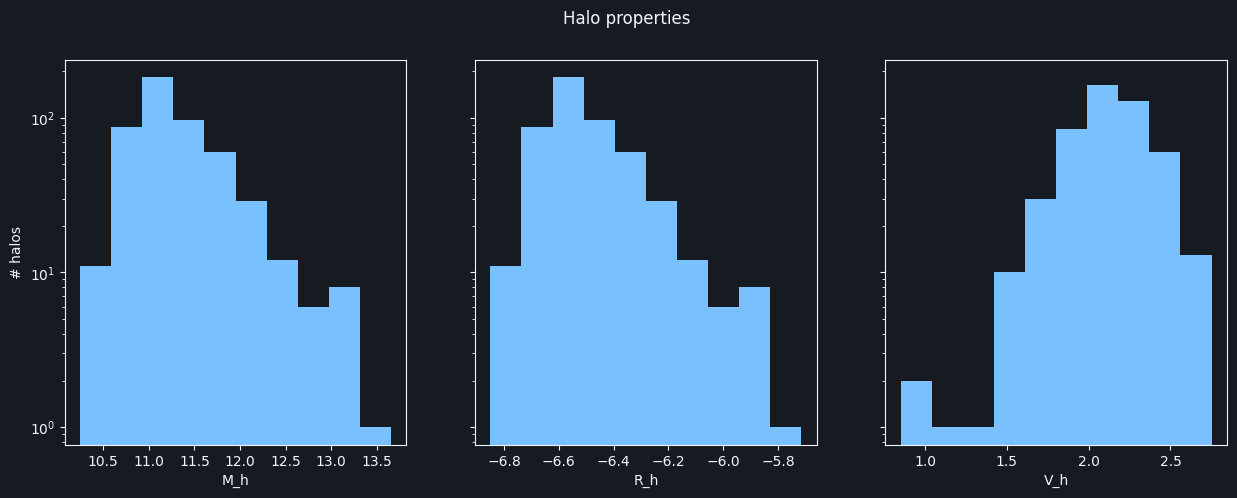

In [23]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'])
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'])
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'])
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

And stellar mass as:

Text(0.5, 1.0, 'Galaxy properties')

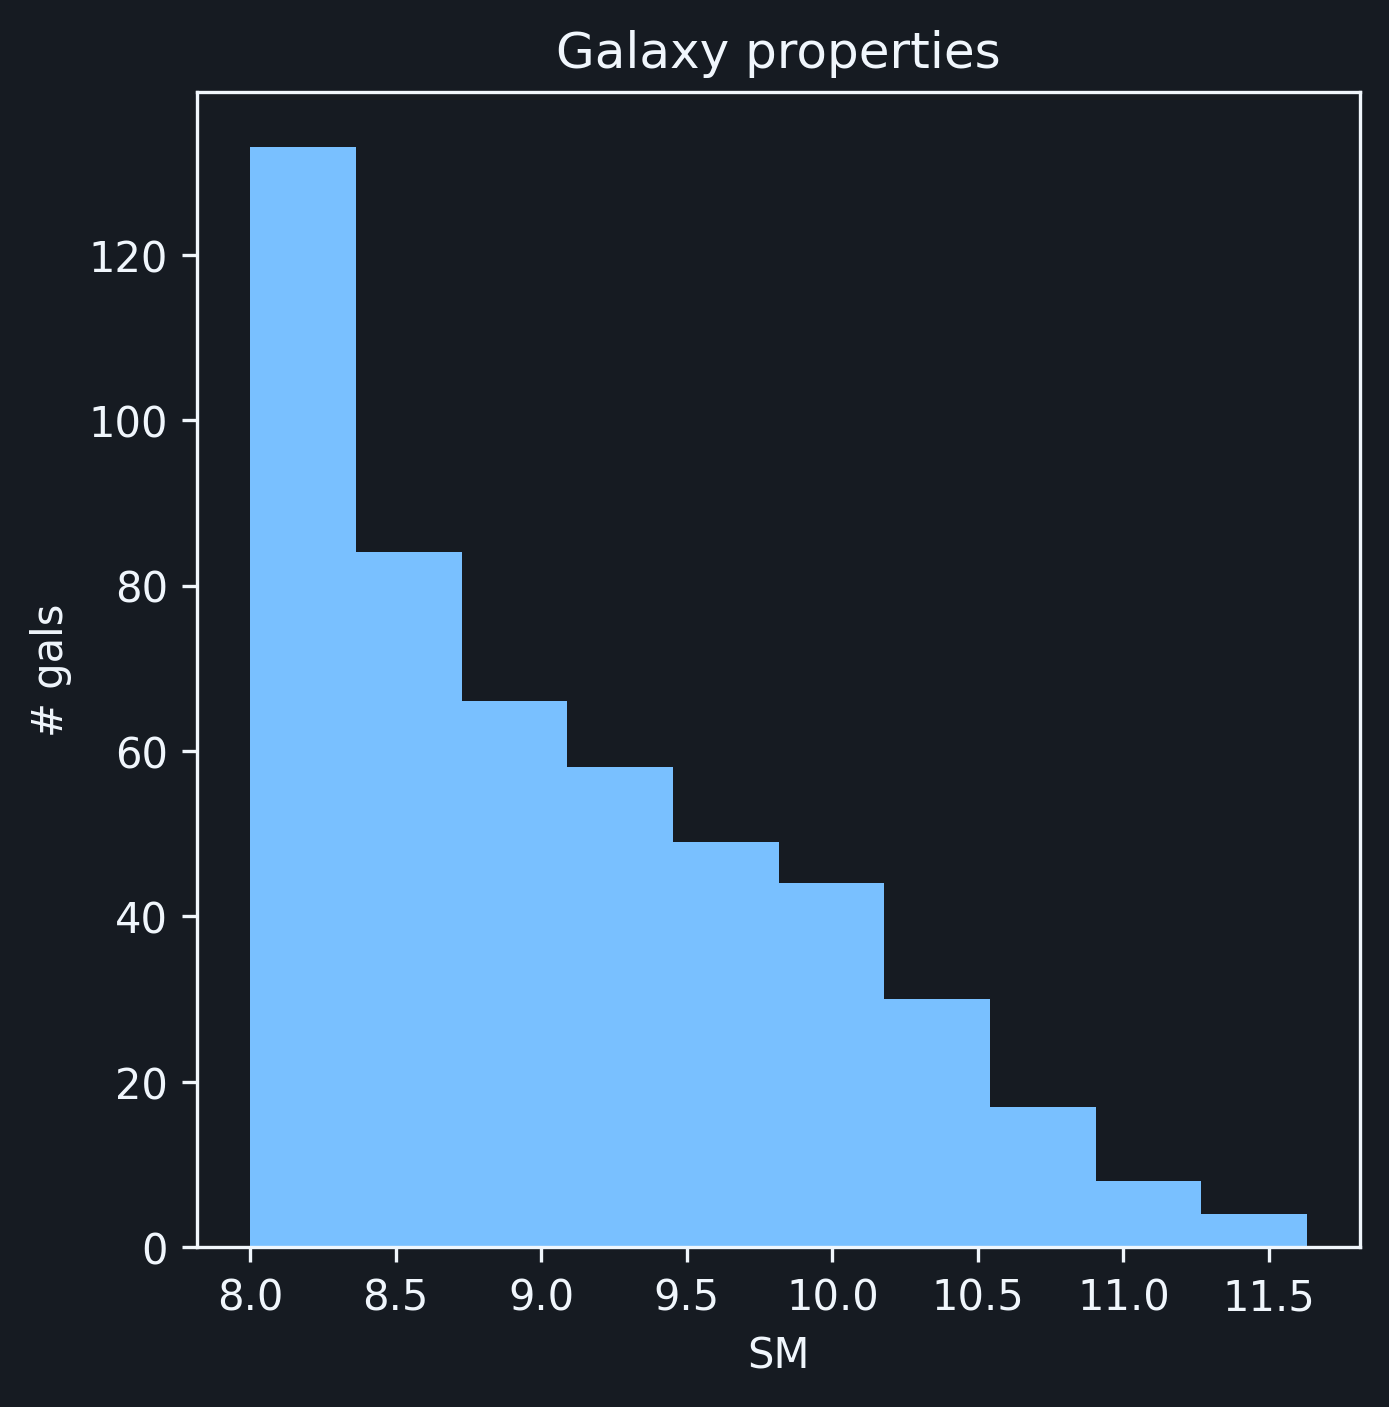

In [24]:
plt.figure(dpi = 300, figsize = (5, 5))
plt.hist(df['SM'])
plt.ylabel('# gals')
plt.xlabel('SM')
plt.title('Galaxy properties')

### 3.3) Measuring the correlation among halo/galaxy properties

Measuring the Pearson Correlation Coefficient (1) and plotting it as a heatmap of the values:

\begin{equation}
 PCC = \frac{ \mathrm{cov} (X, Y) }{ \sigma_X \sigma_Y }
\end{equation}



In [25]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax  = 1.0, center = 0, fmt = '.6f', 
                square=True, linewidths = .5, annot=True, cbar_kws={"shrink": .82})
    plt.title('Pearson Correlation Heatmap')
    plt.show()
    
    return correlations
    

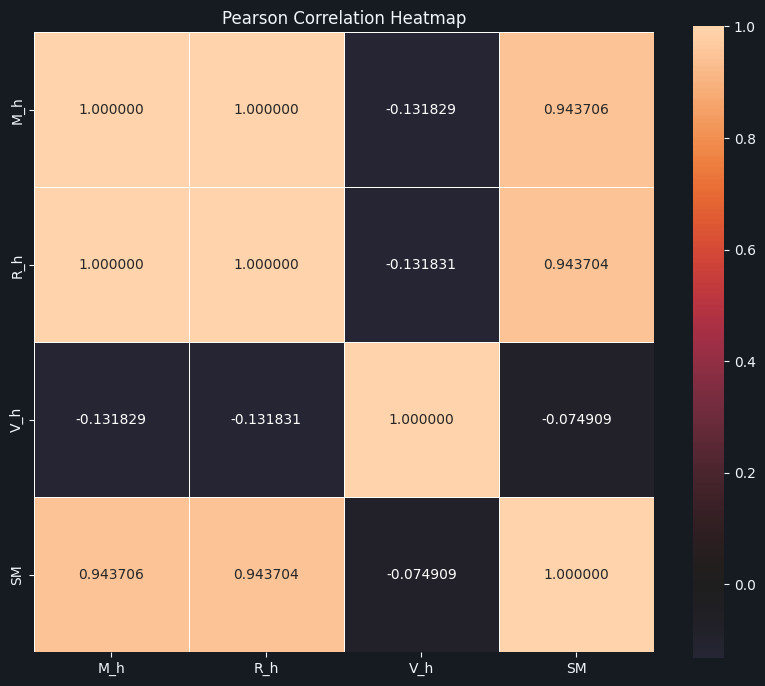

,M_h,R_h,V_h,SM
M_h,1.000000,1.000000,-0.131829,0.943706
R_h,1.000000,1.000000,-0.131831,0.943704
V_h,-0.131829,-0.131831,1.000000,-0.074909
SM,0.943706,0.943704,-0.074909,1.000000


In [26]:
correlation_heatmap(df)

In the above plot we can see:
* 1) The diagonal values are always $1$ (because they represent the correlation of each property with itself)
* 2) Halo masses and radius have a huge correlation to each other
* 3) Otherwise, halo velocities are not huge correlated with the other halo properties
* 4) Because we are interested to get galaxy properties, more specifically stellar mass from halo ones, we are interested in the correlation of them
* 5) Stellar Mass have the higher correlation with halo properties

### 3.4) Machine learning data-pre process:

Selectiong the input (X) and the predicted features (y):

In [51]:
X = np.array([df['M_h'], df['R_h']]).T
y = np.array(df['SM'])
X.shape, y.shape

((493, 2), (493,))

Second, we need to split the data in **train** and **test** sets:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Third, we can transform the data acconding to:
\begin{equation}
 data \Rightarrow \frac{(data - mean)}{std} .
\end{equation}
This transformation is done to constrain the range of all the input variables to small and similar values.

In [53]:
mean_data = np.mean(X_train, axis = 0)
std_data = np.std(X_train, axis = 0)
mean_data, std_data

(array([11.31837815, -6.49310958]), array([0.50427504, 0.16809226]))

In [54]:
X_train = X_train - mean_data
X_train /= std_data
X_test = X_test - mean_data
X_test /= std_data

#### 4) Neural Networks
#### 4.1) Defining the model

In [55]:
def base_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

And we can visualize the model, as well their details, instantiating the model:

In [56]:
my_model = base_model()
my_model

C:\Users\Julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential, built=True>

#### 4.2) Fitting the model

In [57]:
#Fitting data

no_epochs = 100
batch_size = 50
validation_split = 0.2
history = my_model.fit(X_train, y_train, epochs = no_epochs, batch_size = batch_size, validation_split= validation_split)
history

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 82.7200 - val_loss: 79.1513
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 78.1741 - val_loss: 75.1037
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 75.0412 - val_loss: 71.0902
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 71.0409 - val_loss: 66.5662
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 67.1761 - val_loss: 61.4984
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 61.5091 - val_loss: 56.0639
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 56.5768 - val_loss: 50.1633
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 50.3082 - val_loss: 43.9413
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 43.8627 - val_loss: 37.6130
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 37.8817 - val_loss: 31.4377
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 30.7411 - val_loss: 25.7390
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step -

To see if we don't have over/under fitting we can analyse the validation and training losses

In [58]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

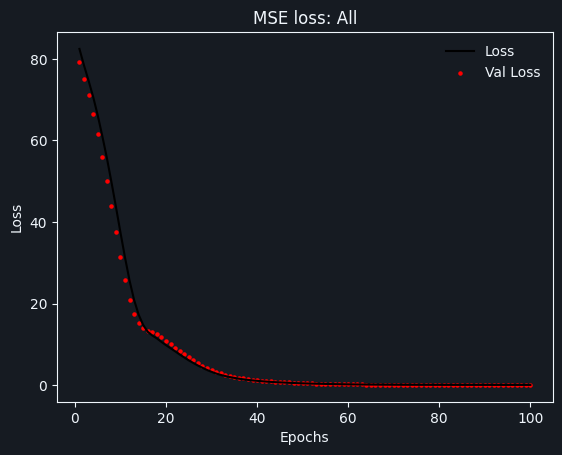

In [59]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black', label = "Loss")
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

#### 4.3) Predictions

In [61]:
prediction = my_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


#### 4.4) Checking for model performance

#### a) MSE


In [63]:
MSE = mean_squared_error(prediction, y_test)
MSE

0.08053015680623597

#### b) Linear comparison

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Julia\AppData\Local\Temp\ipykernel_13708\1592389687.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(y_test, prediction, s = 5, color = 'C0', label = '$M_{\star}$')


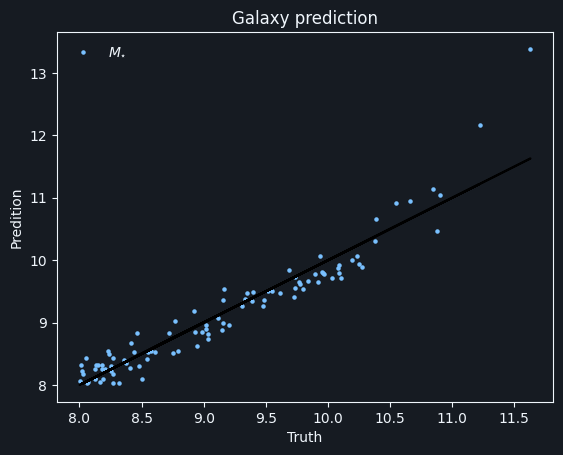

In [64]:
plt.figure(dpi = 100)
plt.title('Galaxy prediction')
plt.scatter(y_test, prediction, s = 5, color = 'C0', label = '$M_{\star}$')
plt.xlabel(r'Truth')
plt.plot(y_test, y_test, color = 'black')
plt.ylabel(r'Predition')
plt.legend()

#### c) Histogram of the complete distribution

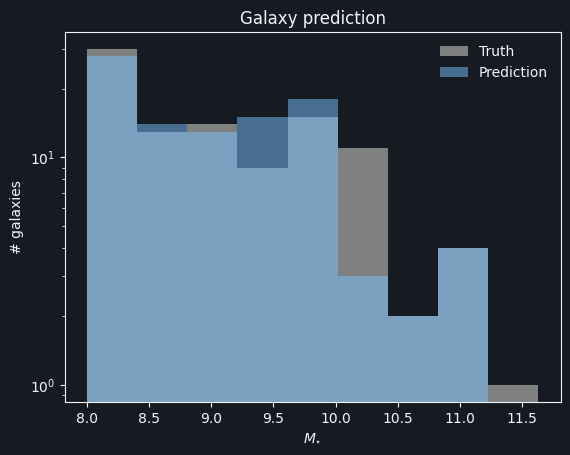

In [70]:
plt.figure(dpi = 100)
plt.title('Galaxy prediction')

bins = np.linspace(np.min(y_test), np.max(y_test), 10)
plt.hist(y_test, bins = bins, color = 'gray', label = 'Truth')
plt.hist(prediction, bins = bins, color = 'C0', alpha = 0.5, label = 'Prediction')
plt.xlabel(r'$M_{\star}$')
plt.ylabel(r'# galaxies')
plt.legend()
plt.yscale('log')
